## **Gaussian Process with Observation Noise**

Real-world processes often involve inherent noise or error that can originate from various sources. The ability to model and account for this observation noise is crucial for building robust and accurate models. Whether it's data collected from sensors, experiments, or any other source, understanding and quantifying the noise in the data can lead to more reliable predictions.

In the world of Gaussian Processes, the default assumption is often that the observation noise is homoskedastic, meaning it remains constant across all data points. However, this assumption may not always hold in practice. In many cases, we have prior knowledge or measurements of the actual noise levels associated with each observation. This knowledge can be invaluable for creating more precise and data-driven models.

This notebook will cover:

- Homoskedastic Gaussian Process (For fixed noise)
- Heteroskedastic Gaussian Process (for varying noise)


In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.0.0
          Server      : http://127.0.0.1:3000
          Environment : /Users/jaspercantwell/Repos/twinLab-Demos/.env



### **Problem Formulation**

Here, we will formulate an exact function to do regression on, and subsequently add noise to the data.


In [2]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2


X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)  # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

### **Homoskedastic GP Emulator**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="fixed_noise_gp"` which must be provided to the `estimator_params` within the `TrainParams` object during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and added to the `TrainParams` object. This additional table must contain the same columns as the mean data. Since the noise model is homoskedastic, the noise must be the same value everywhere.


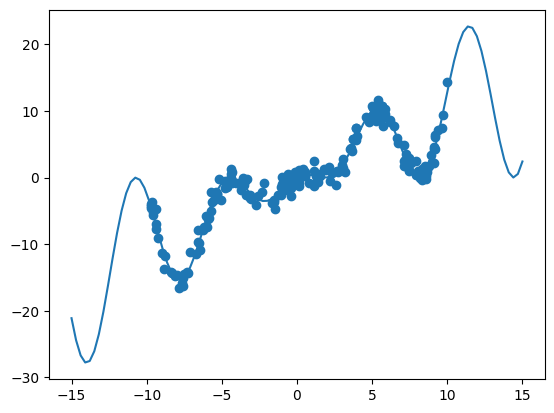

In [3]:
noise_scale = 1.0

# Add noise to data
y_data_homoskedastic = y_data + np.random.normal(scale=noise_scale, size=X_data.shape)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_homoskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": np.full_like(y_data_homoskedastic, noise_scale)})

plt.plot(X, y)
plt.scatter(X_data, y_data_homoskedastic)
plt.show()

In [4]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
dataset = tl.Dataset(dataset_id)
dataset.upload(df)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
std_dataset = tl.Dataset(std_dataset_id)
std_dataset.upload(df_stdev)

In [5]:
# Initialise emulator
emulator_id = "HomoskedasticGP"
emulator = tl.Emulator(emulator_id)

# Define the training and estimator parameters
estimator_params = tl.EstimatorParams(estimator_type="fixed_noise_gp")
params = tl.TrainParams(
    dataset, ["x"], ["y"], dataset_std=std_dataset, estimator_params=estimator_params
)

# Begin training the emulator
emulator.train(params)

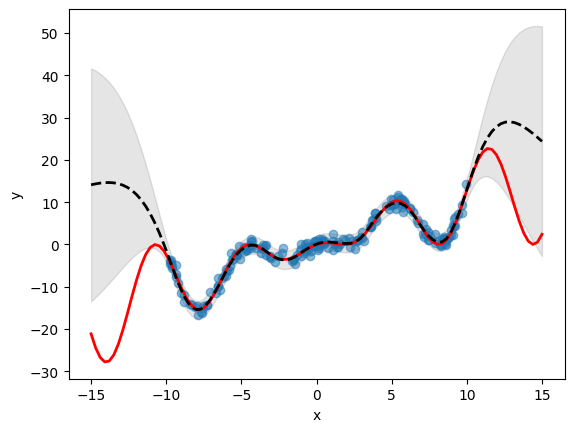

In [6]:
#  Define an evaluation dataset and predicts the outputs using the emulator
eval_data = pd.DataFrame(X, columns=["x"])
df_mean, df_stdev = emulator.predict(eval_data)
y_mean, y_stdev = df_mean.values, df_stdev.values

# Plot inference results
plt.fill_between(
    X.flatten(),
    (y_mean - 1.96 * y_stdev).flatten(),
    (y_mean + 1.96 * y_stdev).flatten(),
    color="k",
    alpha=0.1,
)

plt.scatter(df["x"], df["y"], alpha=0.5, label="Training Data")
plt.xlabel("x")
plt.ylabel("y")

plt.plot(X, y, c="r", linewidth=2)
plt.plot(X, y_mean, c="k", linewidth=2, linestyle="dashed")
plt.show()

### **Heteroskedastic GP Emulator**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="heteroskedastic_gp"` which must be provided to the `estimator_params` within the `TrainParams` object during initialisation.

Additionally, a new `DataFrame` called `df_stdev`, containing the standard deviation of the observation noise/error, must be uploaded and added to the `TrainParams` object. This additional table must contain the same columns as the mean data. Since the noise model is homoskedastic, the noise must be the same value everywhere.


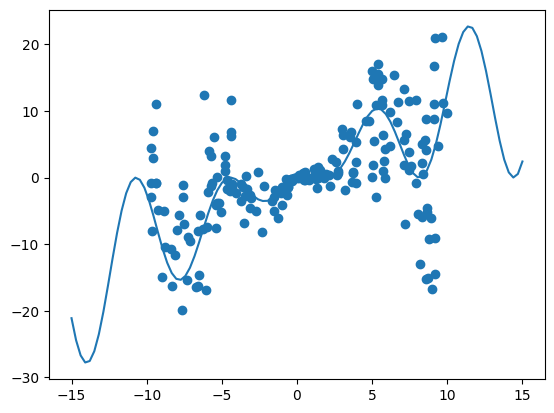

In [7]:
noise_scale = 0.5

# Add noise to data
y_data_heteroskedastic = (
    y_data + np.random.normal(scale=noise_scale, size=X_data.shape[0]) * X_data * 2
)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_heteroskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": X_data * 2})

plt.plot(X, y)
plt.scatter(X_data, y_data_heteroskedastic)
plt.show()

In [8]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
dataset = tl.Dataset(dataset_id)
dataset.upload(df)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
std_dataset = tl.Dataset(std_dataset_id)
std_dataset.upload(df_stdev)

In [ ]:
# Initialise emulator
emulator_id = "HeteroskedasticGP"
emulator = tl.Emulator(emulator_id)

# Define the training and estimator parameters
estimator_params = tl.EstimatorParams(estimator_type="heteroskedastic_gp")
params = tl.TrainParams(
    dataset, ["x"], ["y"], dataset_std=std_dataset, estimator_params=estimator_params
)

# Begin training the emulator
emulator.train(params)

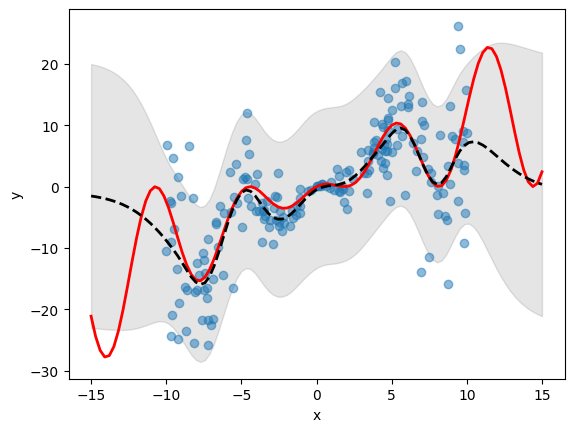

In [ ]:
#  Define an evaluation dataset and predicts the outputs using the emulator
eval_data = pd.DataFrame(X, columns=["x"])
df_mean, df_stdev = emulator.predict(eval_data)
y_mean, y_stdev = df_mean.values, df_stdev.values

plt.fill_between(
    X.flatten(),
    (y_mean - 1.96 * y_stdev).flatten(),
    (y_mean + 1.96 * y_stdev).flatten(),
    color="k",
    alpha=0.1,
)

plt.scatter(df["x"], df["y"], alpha=0.5, label="Training Data")
plt.xlabel("x")
plt.ylabel("y")

plt.plot(X, y, c="r", linewidth=2)
plt.plot(X, y_mean, c="k", linewidth=2, linestyle="dashed")
plt.show()

In [ ]:
# Delete emulator and dataset
emulator.delete()
dataset.delete()
std_dataset.delete()